In [42]:

from ContactMechanics.Systems import NonSmoothContactSystem
from SurfaceTopography.Generation import fourier_synthesis
from matplotlib import pyplot as plt

from Adhesion.Interactions import RepulsiveExponential, Exponential
from ContactMechanics import PeriodicFFTElasticHalfSpace
from Adhesion.System import BoundedSmoothContactSystem,

import numpy as np

np.random.seed(0)

Es = 1
hprms=0.1

0.0


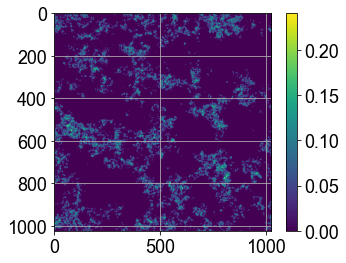

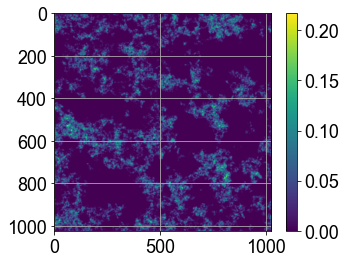

In [46]:
gtol=1e-5
n = 1024

topography = fourier_synthesis(
    (n, n),
    (n, n),
    hurst=0.8,
    rms_slope=0.1,
    short_cutoff=8,
    long_cutoff=n/2,
)
topography = topography.scale(hprms / topography.rms_gradient()).squeeze()
topography._heights = topography.heights() - np.max(topography.heights())

print(np.max(topography.heights()))

substrate = PeriodicFFTElasticHalfSpace(
    (n,n), Es, physical_sizes=(n,n),
    fft='serial')



interaction = RepulsiveExponential(5, 0.1, # repulsive part
                                   5e-8, 1 # attractive part. That's just because I
                                   )#.linearize_core(hardness=1000) # add this if you want to use unbounded minimizers

# Should be the potential Lars used in the PNAS paper. However I cannot set 0 work of adhesion values.
#interaction = LJ93(1, 0.1
#                   ).spline_cutoff(0.1) # sets the work of adhesion to 0
# I use the quadratic potential at high penetrations to avoid overflow in exponential

interaction = Exponential(-5, # negative work of adhesion for repulsion
                          0.1, )



init_disp  = np.zeros((n, n))

offset = 10
system = NonSmoothContactSystem(substrate, topography)
system.minimize_proxy(offset=offset, pentol =1e-4)
plt.figure()
plt.colorbar(plt.imshow(system.force / system.area_per_pt))

# with the softwall interaction

system = BoundedSmoothContactSystem(substrate, interaction, topography)

sol = system.minimize_proxy(offset=offset,
                      initial_displacements=init_disp,
                      options=dict(gtol=gtol * max(Es * topography.rms_gradient(),
                                                  abs(interaction.max_tensile)) * topography.area_per_pt, ftol=0,
                                  maxcor=3), callback=None,
                            lbounds = system._lbounds_from_heights(offset) # you can also shift this to avoid that the constraint becomes active. Having a constraint can help avoiding numerical overflow of the potential
                            )
plt.figure()
plt.colorbar(plt.imshow(system.interaction_force / system.area_per_pt))
# assert that the bound is not active anywhere at the final solution
assert (system.gap > 0 ).all()

